In [1]:
import os
import pandas as pd
import seaborn as sns
from sciviso import Scatterplot
from scircm import SciRCM
from scivae import Vis
import matplotlib.pyplot as plt
import os
import pandas as pd
from collections import defaultdict
from sciutil import SciUtil
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

base_dir = '../data/'
data_dir = f'{base_dir}sircle/F2_DE_output_TvN/'
output_dir = f'{base_dir}sircle/F3_regulatory_clustering/'
fig_dir = '../figures/'
supp_dir = f'{base_dir}raw_downloads/supps/'
gene_name = 'hgnc_symbol'
save_fig = False
test_title = 'all_patients_ccRCC'


## Filter DNA methylation genes

Here we want to assign 1 CpG to each gene (i.e. we want to identify the "driver" CpG).  

We determine this by first finding CpGs that are in agreement in terms of direction of regulation.  

1) Group CpGs that fall within 1000 bp of the TSS  
2) If there are at least 3 CpGs then check that at least 60% of CpGs argree in terms of direction of change (and have a pvalue < 0.1)  
3) If they do then retain the CpG with the largest DNA methylation difference (in the direction that 60% agreed on)  
4) If there were less than 3 CpGs just keep the CpG with the largest DNA methylation difference. 
`

In [2]:
from scircm import filter_methylation_data_by_genes
u = SciUtil()
meth_df = pd.read_csv(f'{data_dir}cpg_DE_{test_title}_sircle.csv')
# t value = t, adj.P.Val = adjusted P, cpg_id = CpG id, logFC=logfold change
# Only include those with a adj p value < 0.1
run_meth_filter = True

# Replace inf
# replace logFC col neg and +ve inf
meth_df['logFC_meth'].replace([np.inf],max(meth_df['logFC_meth'].replace(np.inf, np.nan)),inplace=True)
meth_df['logFC_meth'].replace([-np.inf],min(meth_df['logFC_meth'].replace(-np.inf, np.nan)),inplace=True)
normal_cols = [c for c in meth_df.columns if 'Normal' in c]
tumor_cols = [c for c in meth_df.columns if 'Tumor' in c]
beta_diff = np.mean(meth_df[tumor_cols].values, axis=1) - np.mean(meth_df[normal_cols].values, axis=1)
meth_df['CpG_Beta_diff'] = beta_diff

# Filter the methylation data to only 
meth_f_df = filter_methylation_data_by_genes(meth_df, 'ensembl_gene_id', 'padj_meth', 'CpG_Beta_diff')


--------------------------------------------------------------------------------
      Originally had: 	25434	genes.
	Filtered DF now has: 	21377	 genes.	       
--------------------------------------------------------------------------------


In [3]:
meth_f_df.to_csv(f'{data_dir}filtered_cpg_DE_{test_title}_sircle.csv', index=False)

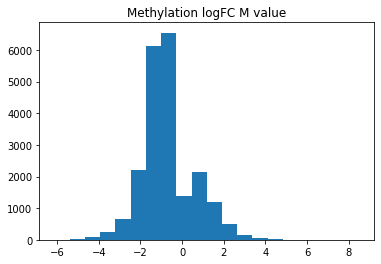

In [4]:
plt.hist(meth_f_df['logFC_meth'], bins=20)
plt.title('Methylation logFC M value')
plt.show()

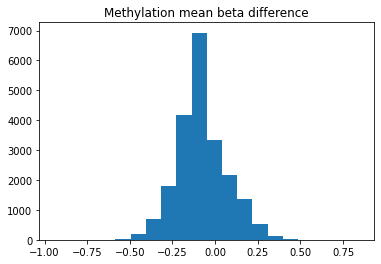

In [5]:
mean_change = np.mean(meth_f_df[[c for c in meth_f_df.columns if 'Tumor' in c]].values, axis=1) - np.mean(meth_f_df[[c for c in meth_f_df.columns if 'Normal' in c]].values, axis=1)
plt.hist(mean_change, bins=20)
plt.title('Methylation mean beta difference')
plt.show()

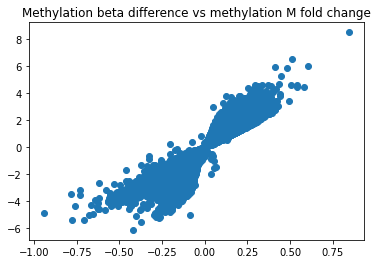

In [6]:
plt.scatter(meth_f_df["CpG_Beta_diff"].values, meth_f_df["logFC_meth"].values)
plt.title('Methylation beta difference vs methylation M fold change')
plt.show()

## Look at how many genes had multiple CpGs

In [7]:
gene_counts = meth_df['ensembl_gene_id'].value_counts()
print("Number of genes with less than 3 CpGs:", len(gene_counts[gene_counts < 3]), 
      "\nNumber of genes with between 3 and 20 CpGs:", len(gene_counts[gene_counts > 3]), 
      "\nNumber of genes with greater than 20 CpGs:", len(gene_counts[gene_counts > 20])) #6713 15848 1400
# As an example, show the number of  genes for a given one
meth_df[meth_df['external_gene_name'] == 'CA9']

Number of genes with less than 3 CpGs: 6713 
Number of genes with between 3 and 20 CpGs: 15848 
Number of genes with greater than 20 CpGs: 1400


,Unnamed: 0,Locus,chr,pos,ensembl_gene_id,external_gene_name,hgnc_symbol,entrezgene_id,Relation_to_Island,UCSC_RefGene_Group,...,CpG_Normal_d781be9c.7b3b.4acf.b202.d4d4b847db05_1,CpG_Normal_62bcce15.fdaf.49d4.9bed.24a493f5776b_1,CpG_Normal_e3ed1380.d6f1.420e.b6a6.d24a6e81a364_1,CpG_Normal_c92995d5.68ce.47d0.8149.0323e624c032_1,CpG_Normal_f29b6c8c.d713.42ad.9b90.e556df9b05cd_1,CpG_Normal_cb371398.ee48.4665.8089.26229c5b2cf0_1,CpG_Normal_ac092a8e.80af.4589.8bb8.d86427b398ca_1,CpG_Normal_318f6ffb.1fdf.4f74.90db.21e337503aae_1,CpG_Normal_ef9ae1dd.83aa.404d.83ef.ced707ae738b_1,CpG_Beta_diff
53104,cg06908460,cg06908460,chr9,35676107,ENSG00000107159,CA9,CA9,768,Island,Body,...,0.071525,0.073432,0.056048,0.061662,0.057470,0.061828,0.089296,0.060925,0.075332,0.013317
71975,cg09566069,cg09566069,chr9,35676368,ENSG00000107159,CA9,CA9,768,Island,Body,...,0.188227,0.189941,0.207914,0.189651,0.196477,0.184108,0.335658,0.183858,0.252410,0.056579
100054,cg13849253,cg13849253,chr9,35676169,ENSG00000107159,CA9,CA9,768,Island,Body,...,0.041222,0.067208,0.049146,0.054657,0.035332,0.081421,0.117577,0.047883,0.069222,0.002398
105670,cg14563831,cg14563831,chr9,35679278,ENSG00000107159,CA9,CA9,768,S_Shelf,Body,...,0.890417,0.940949,0.922212,0.921867,0.934773,0.919804,0.938456,0.893177,0.923882,-0.021328
135379,cg19257550,cg19257550,chr9,35673912,ENSG00000107159,CA9,CA9,768,N_Shore,TSS200,...,0.545057,0.590555,0.494968,0.602210,0.731530,0.526126,0.595478,0.549169,0.736935,-0.038873
143713,cg20610181,cg20610181,chr9,35674003,ENSG00000107159,CA9,CA9,768,N_Shore,1stExon,...,0.812362,0.863635,0.851431,0.850729,0.945040,0.831214,0.802052,0.889678,0.895687,-0.363275


# Save as a bed file so we can easily see which one we chose using IGV

In [8]:
# Save the locus, chr, pos, and gene name to a CSV (along with cpgBetaDiff) to use for the peak files
meth_to_save = meth_df[['Locus', 'chr', 'pos', 'external_gene_name', 'CpG_Beta_diff', 'padj_meth']]
meth_to_save['Sig'] = ['*' if c < 0.05 else '' for c in meth_df['padj_meth'].values]
loci = {}
for l in meth_f_df['Locus'].values:
    loci[l] = True
    chosen=[]
for l in meth_to_save['Locus'].values:
    if loci.get(l):
        chosen.append('+')
    else:
        chosen.append(" ")
meth_to_save['Chosen'] = chosen


meth_to_save['Name'] = meth_to_save['Chosen'] + meth_to_save['Locus'] + '(' + meth_to_save['Sig'] + meth_to_save['external_gene_name'] + ')'

meth_to_save.to_csv(f'{data_dir}cpg_DE_{test_title}_sircle_locus_info.csv')
meth_f_df[['Locus', 'chr', 'pos', 'external_gene_name', 'CpG_Beta_diff', 'padj_meth']].to_csv(f'{data_dir}cpg_filtered_DE_{test_title}_sircle_locus_info.csv')

# Just using this to convert to a bed easily.

from scie2g.csv import Csv, Epi2GeneException

# We read in the file and then convert it to a BED file so that we can load it in IGV
filepath = f'{data_dir}cpg_DE_{test_title}_sircle_locus_info.csv'
df = pd.read_csv(filepath)
f = Csv(filepath,  'chr', 'pos', 'pos', 'CpG_Beta_diff', ['Locus', 'external_gene_name'], sep=',')
f.convert_to_bed(df, f'{output_dir}cpg_DE_all_patients_ccRCC_sircle_locus.bed',
                 'CPTAC TCGA CpG', None, 'Name')

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_95902/1752484273.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meth_to_save['Sig'] = ['*' if c < 0.05 else '' for c in meth_df['padj_meth'].values]
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_95902/1752484273.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meth_to_save['Chosen'] = chosen
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_95902/1752484273.py:16: SettingWithCopyWarning: 
A value is trying to be set on

## Plot the CpGs: supplementary figure

Here we want to plot the CpGs and how they map to genes, also report the total number of "up" and "down" CpGs.


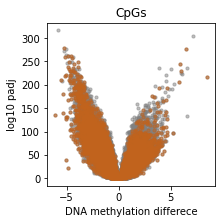

--------------------------------------------------------------------------------
       Original number of CpGs: 	187770	 Filtered number of CpGs: 	21377	       
--------------------------------------------------------------------------------


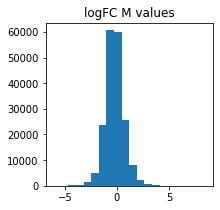

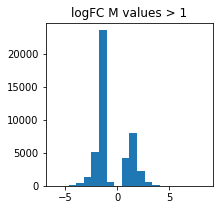

In [9]:
"""
---------------------------------------------------------------
            Plot and identify the largest direction of change for the CpGs
---------------------------------------------------------------
"""

plt.rcParams["figure.figsize"] = (3,3)

# Plot a scatter in grey of the original dataset
plt.scatter(meth_df['logFC_meth'].values, -1 * np.log10(meth_df['padj_meth'].values), c='grey', alpha=0.5, s=10)
# plot a scatter in colour for the filtered dataset 
plt.scatter(meth_f_df['logFC_meth'].values, -1 * np.log10(meth_f_df['padj_meth'].values), c='#C2631D', s=10,
            alpha=0.5)
plt.title('CpGs')
plt.xlabel('DNA methylation differece')
plt.ylabel('log10 padj')
if save_fig:
    plt.savefig(f'{fig_dir}SFig1_CpGs_{test_title}.svg')
plt.show()

# Print the respective sizes of the datasets
u.dp(['Original number of CpGs: ', len(meth_df), ' Filtered number of CpGs: ', len(meth_f_df)])

plt.hist(meth_df['logFC_meth'].values, bins=20)
plt.title('logFC M values')
plt.show()

plt.hist(meth_df['logFC_meth'].values[np.where(abs(meth_df['logFC_meth'].values) > 1.0)], bins=20)
plt.title('logFC M values > 1')
plt.show()


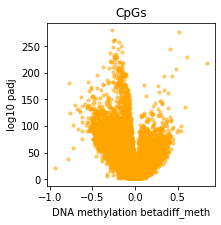

--------------------------------------------------------------------------------
       Original number of CpGs: 	187770	 Filtered number of CpGs: 	21377	       
--------------------------------------------------------------------------------


In [10]:
"""
---------------------------------------------------------------
            Plot and identify the largest direction of change for the CpGs
---------------------------------------------------------------
"""
plt.rcParams["figure.figsize"] = (3,3)

# Save the meth DF to csv
#meth_f_df.to_csv(meth_filtered_file, index=False)
plt.scatter(meth_f_df['CpG_Beta_diff'].values, -1 * np.log10(meth_f_df['padj_meth'].values), c='orange', alpha=0.5, s=10)

# plot a scatter in colour for the filtered dataset 
plt.title('CpGs')
plt.xlabel('DNA methylation betadiff_meth')
plt.ylabel('log10 padj')
if save_fig:
    plt.savefig(f'{fig_dir}SFig1_CpGs_beta_{meth_test_title}.svg')
plt.show()

# Print the respective sizes of the datasets
u.dp(['Original number of CpGs: ', len(meth_df), ' Filtered number of CpGs: ', len(meth_f_df)])



In [11]:
m_cutoff = 1.0
# Print out the number of hypo and hyper methylated genes
u.dp(['Original Hyper-methylated:',  len(meth_df[meth_df['logFC_meth'].values > m_cutoff]), 
      'Original Hypo-methylated:',len(meth_df[meth_df['logFC_meth'].values < -m_cutoff])])

u.warn_p(['Filtered Hyper-methylated:',  len(meth_f_df[meth_f_df['logFC_meth'].values > m_cutoff]), 
          'Filtered Hypo-methylated:', len(meth_f_df[meth_f_df['logFC_meth'].values < -m_cutoff])])
        
u.dp(['Percentage All Hyper-methylated:', 100*(len(meth_df[meth_df['logFC_meth'].values > m_cutoff])/len(meth_df)), 
     'Percentage All Hypo-methylated:', 100*(len(meth_df[meth_df['logFC_meth'].values < -m_cutoff])/len(meth_df))])
      
u.warn_p(['Percentage Filtered Hyper-methylated:', 100*(len(meth_f_df[meth_f_df['logFC_meth'].values > m_cutoff])/len(meth_f_df)), 
     'Percentage Filtered Hypo-methylated:', 100*(len(meth_f_df[meth_f_df['logFC_meth'].values < -m_cutoff])/len(meth_f_df))])
      

--------------------------------------------------------------------------------
       Original Hyper-methylated:	15306	Original Hypo-methylated:	31140	        
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
        Filtered Hyper-methylated:	2474	Filtered Hypo-methylated:	9450	         
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Percentage All Hyper-methylated:	8.151461894871385	Percentage All Hypo-methylated:	16.584118868828888	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Percentage Filtered Hyper-methylated:	11.573186134630678	Percentage Filtered Hypo-methylated:	44.20639004537587	
-------------------------------------------------------

In [12]:
m_cutoff = 0.5
# Print out the number of hypo and hyper methylated genes
u.dp(['Original Hyper-methylated:',  len(meth_df[meth_df['CpG_Beta_diff'].values > m_cutoff]), 
      'Original Hypo-methylated:',len(meth_df[meth_df['CpG_Beta_diff'].values < -m_cutoff])])

u.warn_p(['Filtered Hyper-methylated:',  len(meth_f_df[meth_f_df['CpG_Beta_diff'].values > m_cutoff]), 
          'Filtered Hypo-methylated:', len(meth_f_df[meth_f_df['CpG_Beta_diff'].values < -m_cutoff])])
        
u.dp(['Percentage All Hyper-methylated:', 100*(len(meth_df[meth_df['CpG_Beta_diff'].values > m_cutoff])/len(meth_df)), 
     'Percentage All Hypo-methylated:', 100*(len(meth_df[meth_df['CpG_Beta_diff'].values < -m_cutoff])/len(meth_df))])
      
u.warn_p(['Percentage Filtered Hyper-methylated:', 100*(len(meth_f_df[meth_f_df['CpG_Beta_diff'].values > m_cutoff])/len(meth_f_df)), 
     'Percentage Filtered Hypo-methylated:', 100*(len(meth_f_df[meth_f_df['CpG_Beta_diff'].values < -m_cutoff])/len(meth_f_df))])
      

--------------------------------------------------------------------------------
          Original Hyper-methylated:	20	Original Hypo-methylated:	66	           
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
           Filtered Hyper-methylated:	7	Filtered Hypo-methylated:	54	           
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Percentage All Hyper-methylated:	0.010651328753261968	Percentage All Hypo-methylated:	0.0351493848857645	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Percentage Filtered Hyper-methylated:	0.03274547410768583	Percentage Filtered Hypo-methylated:	0.2526079431164336	
--------------------------------------------------

## Correlation between the input features: Figure 1 A

Plot the correlation between the input features of the datasets.

--------------------------------------------------------------------------------
    Pearson correlation between RNAseq and Protein: 	0.6363288467228314	0.0	    
--------------------------------------------------------------------------------


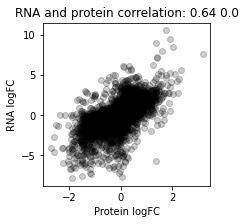

In [13]:
from scipy.stats import pearsonr

prot_df = pd.read_csv(f'{data_dir}prot_DE_{test_title}_sircle.csv')
rna_df = pd.read_csv(f'{data_dir}rna_DE_{test_title}_sircle.csv')


genes = list(set(prot_df['ensembl_gene_id'].values)&set(rna_df['ensembl_gene_id'].values))
v_r = rna_df[rna_df.set_index('ensembl_gene_id').index.isin(genes)].sort_values('ensembl_gene_id')
v_p = prot_df[prot_df.set_index('ensembl_gene_id').index.isin(genes)].sort_values('ensembl_gene_id')
v_p.drop_duplicates(subset='ensembl_gene_id', inplace=True)
v_r.drop_duplicates(subset='ensembl_gene_id', inplace=True)

plt.scatter( v_p['logFC_protein'].values, v_r['logFC_rna'].values, alpha=0.2, c='k')
corr, p_corr = pearsonr( v_p['logFC_protein'].values, v_r['logFC_rna'].values)
plt.title(f'RNA and protein correlation: {round(corr, 2)} {round(p_corr, 2)}')
plt.xlabel('Protein logFC')
plt.ylabel('RNA logFC')

if save_fig:
    plt.savefig(f'{fig_dir}Fig1A_RNA_Protein_corr.svg')

# Print out the pearson correlation
u.dp(['Pearson correlation between RNAseq and Protein: ', corr, p_corr])


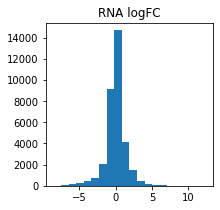

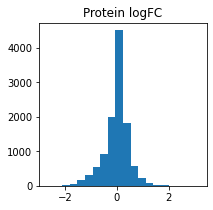

In [14]:
plt.hist(rna_df['logFC_rna'].values, bins=20)
plt.title('RNA logFC')
plt.show()


plt.hist(prot_df['logFC_protein'].values, bins=20)
plt.title('Protein logFC')
plt.show()

## Test copula correlation

In [15]:
print(np.std(v_p['logFC_protein'].values), np.std(v_r['logFC_rna'].values))

0.4894415774554938 1.2030189680500991


--------------------------------------------------------------------------------
    Pearson correlation between RNAseq and Protein: 	0.6709383907979879	0.0	    
--------------------------------------------------------------------------------


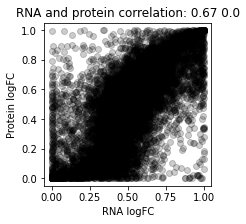

In [16]:
from scipy.stats import norm
rna_cdf = norm.cdf(v_r['logFC_rna'].values, 0, 1.4)
prot_cdf = norm.cdf(v_p['logFC_protein'].values, 0, 0.5)
plt.scatter(rna_cdf, prot_cdf, alpha=0.2, c='k')
corr, p_corr = pearsonr(rna_cdf, prot_cdf)
plt.title(f'RNA and protein correlation: {round(corr, 2)} {round(p_corr, 2)}')
plt.xlabel('RNA logFC')
plt.ylabel('Protein logFC')
u.dp(['Pearson correlation between RNAseq and Protein: ', corr, p_corr])
plt.show()

## Combine RNA and methylation data

In [17]:
genes = list(set(meth_df['external_gene_name'].values)&set(rna_df['external_gene_name'].values))
v_r = rna_df[rna_df.set_index('external_gene_name').index.isin(genes)].sort_values('external_gene_name')
v_p = meth_df[meth_df.set_index('external_gene_name').index.isin(genes)].sort_values('external_gene_name')

rna_meth = v_p.join(v_r, lsuffix='', rsuffix='_')
rna_meth

,Unnamed: 0,Locus,chr,pos,ensembl_gene_id,external_gene_name,hgnc_symbol,entrezgene_id,Relation_to_Island,UCSC_RefGene_Group,...,RNA_Tumor_C3N.01524_3,RNA_Normal_C3N.01646_1,RNA_Tumor_C3N.01646_1,RNA_Normal_C3N.01648_1,RNA_Normal_C3N.01649_1,RNA_Tumor_C3N.01649_1,RNA_Normal_C3N.01651_1,RNA_Tumor_C3N.01651_1,RNA_Normal_C3N.01808_1,RNA_Tumor_C3N.01808_1
166341,cg24393602,cg24393602,chr6,52995606,ENSG00000202198,7SK,0,0,S_Shore,TSS1500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66855,cg08830754,cg08830754,chr6,52995436,ENSG00000202198,7SK,0,0,S_Shore,TSS200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155112,cg22568540,cg22568540,chr19,58353480,ENSG00000121410,A1BG,A1BG,1,N_Shelf,Body;5'UTR;1stExon,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124590,cg17498272,cg17498272,chr19,58353563,ENSG00000121410,A1BG,A1BG,1,N_Shelf,Body;TSS200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59196,cg07739758,cg07739758,chr19,58354001,ENSG00000121410,A1BG,A1BG,1,N_Shelf,Body;TSS1500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134548,cg19105961,cg19105961,chr17,4142929,ENSG00000074755,ZZEF1,ZZEF1,23140,Island,TSS1500;5'UTR;1stExon;TSS1500;TSS1500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19873,cg02459389,cg02459389,chr17,4019718,ENSG00000074755,ZZEF1,ZZEF1,23140,OpenSea,Body,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11060,cg01341891,cg01341891,chr1,77682042,ENSG00000036549,ZZZ3,ZZZ3,26009,N_Shore,5'UTR,...,7.532377,6.027899,7.85286,6.769411,5.845572,8.083454,7.000563,8.019076,7.010768,7.782185
167499,cg24577193,cg24577193,chr1,77682711,ENSG00000036549,ZZZ3,ZZZ3,26009,Island,TSS200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------------------------------------------------------------
Pearson correlation between RNAseq and DNA methylation: 	-0.0039863098067630925	0.6272710460579092	
--------------------------------------------------------------------------------


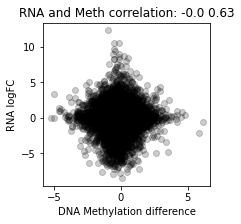

In [18]:

plt.scatter(rna_meth['logFC_meth'].values, rna_meth['logFC_rna'].values, alpha=0.2, c='k')
rna_meth = rna_meth.dropna()

corr, p_corr = pearsonr(rna_meth['logFC_meth'].values, rna_meth['logFC_rna'].values)
plt.title(f'RNA and Meth correlation: {round(corr, 2)} {round(p_corr, 2)}')
plt.xlabel('DNA Methylation difference')
plt.ylabel('RNA logFC')
if save_fig:
    plt.savefig(f'{fig_dir}Fig1A_RNA_Meth_corr_{meth_test_title}.svg')
# Print out the pearson correlation
u.dp(['Pearson correlation between RNAseq and DNA methylation: ', corr, p_corr])

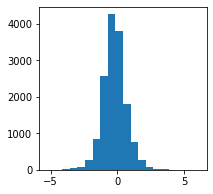

--------------------------------------------------------------------------------
Pearson correlation between RNAseq and DNA methylation Beta: 	-0.17269911428758203	3.3929936065564195e-114	
--------------------------------------------------------------------------------


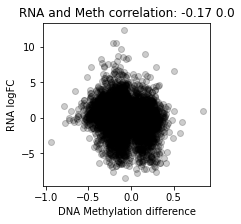

Text(0, 0.5, 'RNA logFC')

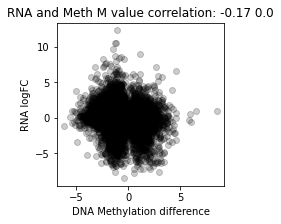

In [19]:
plt.hist(rna_meth['logFC_meth'].values, bins=20)
plt.show()
genes = list(set(meth_f_df['ensembl_gene_id'].values)&set(rna_df['ensembl_gene_id'].values))
rna_df.set_index('ensembl_gene_id', inplace=True)
v_r = rna_df[rna_df.index.isin(genes)].sort_values('ensembl_gene_id')
meth_f_df.set_index('ensembl_gene_id', inplace=True)
v_p = meth_f_df[meth_f_df.index.isin(genes)].sort_values('ensembl_gene_id')
rna_meth = v_p.join(v_r, lsuffix='', rsuffix='_')
rna_meth
plt.scatter(v_p['CpG_Beta_diff'].values, v_r['logFC_rna'].values, alpha=0.2, c='k')
corr, p_corr = pearsonr(v_p['CpG_Beta_diff'].values, v_r['logFC_rna'].values)
plt.title(f'RNA and Meth correlation: {round(corr, 2)} {round(p_corr, 2)}')
plt.xlabel('DNA Methylation difference')
plt.ylabel('RNA logFC')
if save_fig:
    plt.savefig(f'{fig_dir}Fig1A_RNA_Meth_Beta_corr_{meth_test_title}.svg')
# Print out the pearson correlation
u.dp(['Pearson correlation between RNAseq and DNA methylation Beta: ', corr, p_corr])
plt.show()

# Also do M value
plt.scatter(v_p['logFC_meth'].values, v_r['logFC_rna'].values, alpha=0.2, c='k')
corr, p_corr = pearsonr(v_p['CpG_Beta_diff'].values, v_r['logFC_rna'].values)
plt.title(f'RNA and Meth M value correlation: {round(corr, 2)} {round(p_corr, 2)}')
plt.xlabel('DNA Methylation difference')
plt.ylabel('RNA logFC')